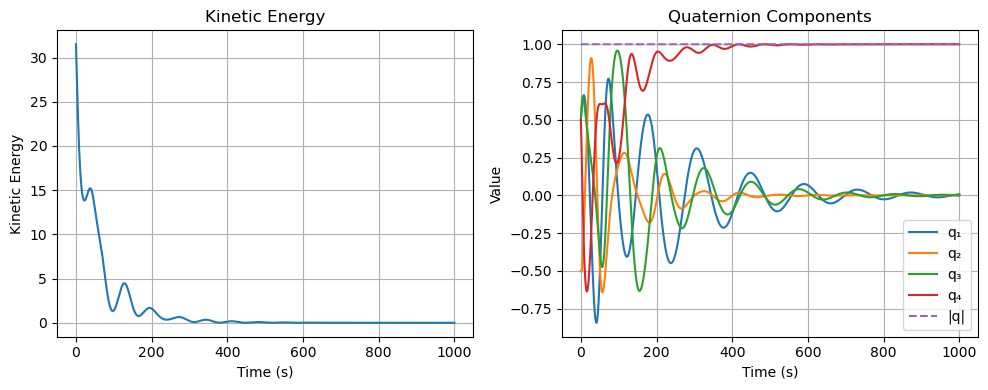

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
A = 1000
B = 500 
C = 800
J = [A, B, C]
J_m = np.diag(J)

# Helper functions
def E_matrix(q):
    qs = q[3]
    qv = q[:3]
    E = np.zeros((4, 3))
    E[:3, :] = qs * np.eye(3) + skew(qv)
    E[3:, :] = -qv
    return E

def skew(v):
    return np.array([[0, -v[2], v[1]], 
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

def EulerPD(w0, J, N):
    A, B, C = J
    dw0_x = (B - C) / A * w0[1] * w0[2] + N[0] / A
    dw0_y = (C - A) / B * w0[0] * w0[2] + N[1] / B
    dw0_z = (A - B) / C * w0[0] * w0[1] + N[2] / C
    return np.array([dw0_x, dw0_y, dw0_z])

def quatMultiply(q1, q2):
    q1s, q1v = q1[3], q1[:3]
    q2s, q2v = q2[3], q2[:3]
    q3s = q1s * q2s - np.dot(q2v, q1v)
    q3v = q1s * q2v + q2s * q1v - np.cross(q2v, q1v)
    return np.concatenate([q3v, [q3s]])

# Initial conditions
omega_0 = np.array([0.2, -0.1, 0.15])
q = np.array([0.5, -0.5, 0.5, 0.5])
q_r = np.array([0, 0, 0, 1])

# Control parameters
Kp = 4
Kd = 10

# Initialize variables
w = omega_0.copy()
t = 0
dt = 0.1  # Reduced time step for better stability
t_end = 1000  # Reduced simulation time
time = [t]
q1, q2, q3, q4, qnorm = [q[0]], [q[1]], [q[2]], [q[3]], [np.linalg.norm(q)]
T = [0.5 * w @ J_m @ w]
normN = []

# Simulation loop
while t < t_end:
    # Current quaternion error
    Beta = quatMultiply(q, q_r)
    Beta_v = Beta[:3]
    Beta_s = Beta[3]

    # Control torque
    w_e = w
    N = -Kp * Beta_v - Kd * w_e
    normN.append(np.linalg.norm(N))

    # Derivatives
    w_dot = EulerPD(w, J, N)
    q_dot = 0.5 * E_matrix(q) @ w

    # Update states using Euler integration
    q_new = q + q_dot * dt
    q = q_new / np.linalg.norm(q_new)  # Normalize quaternion
    w = w + w_dot * dt

    # Store results
    time.append(t + dt)
    q1.append(q[0])
    q2.append(q[1])
    q3.append(q[2])
    q4.append(q[3])
    qnorm.append(np.linalg.norm(q))
    T.append(0.5 * w @ J_m @ w)

    t += dt

# Plot results
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(time, T)
plt.title('Kinetic Energy')
plt.xlabel('Time (s)')
plt.ylabel('Kinetic Energy')
plt.grid(True)

plt.subplot(122)
plt.plot(time, q1, label='q₁')
plt.plot(time, q2, label='q₂')
plt.plot(time, q3, label='q₃')
plt.plot(time, q4, label='q₄')
plt.plot(time, qnorm, '--', label='|q|')
plt.legend()
plt.title('Quaternion Components')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.grid(True)

plt.tight_layout()
plt.show()